In [1]:
#| default_exp activations

# Activation stats
For most machine learning practitioners, their model and corresponding performance are often a black box. This need not be the case. Instead of randomly trying different options, we can monitor the activations of the model to figure out what is wrong.

This notebook will be an attempt to show us how.

In [2]:
#|export
from __future__ import annotations
import random, math, torch, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [3]:
import torch.nn.functional as F, matplotlib as mpl
from pathlib import Path
from operator import attrgetter, itemgetter
from contextlib import contextmanager

from torch import tensor, nn, optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [4]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [5]:
x,y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

## Baseline

In [7]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1, 8, ks=5), # 14 by 14
        conv(8, 16), # 7 by 7
        conv(16, 32), # 4 by 4
        conv(32, 64), # 2 by 2
        conv(64, 19, act=False), # 1 by 1
        nn.Flatten()
    ]

In [8]:
from torcheval.metrics import MulticlassAccuracy

In [9]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [10]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=fc.L(xtra_cbs)+cbs)
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.129,0.000,0,train
0.100,0.000,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


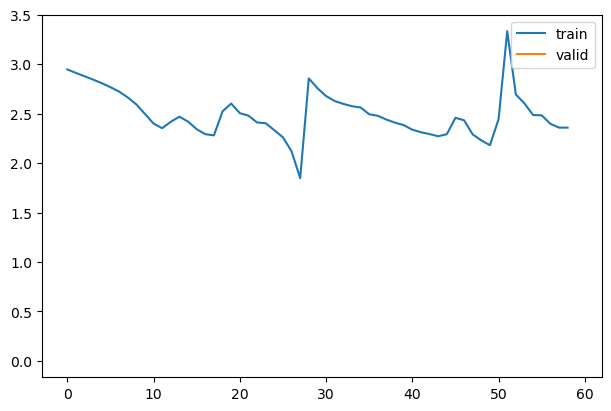

In [11]:
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks
Hooks are similar to callbacks. For the purpose of this notebook, just assume they serve similar purpose.

We will now use hooks to keep track of the activation mean and standard deviation for each layer in our model.

### Manual insertion

In [12]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            # additional code here to take note of mean and std of activation
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x
    
    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.129,0.000,0,train
0.100,0.000,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

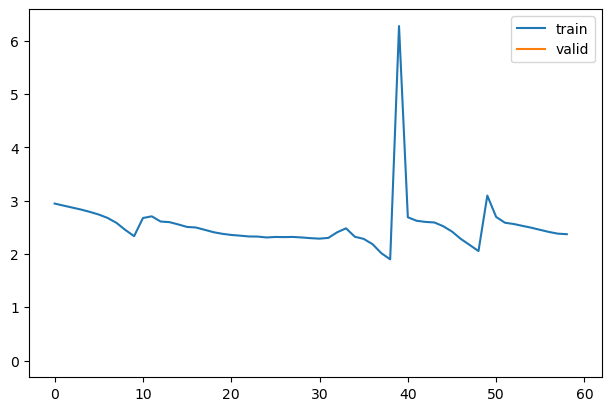

In [13]:
model = SequentialModel(*cnn_layers())
learn = fit(model)

In our ideal situation, we want the activation of each model layer's mean to be around 0 and std to be around 1 (a normal distribution). This is a 'well-behaved' model where we don't get extremes. Let's see what our model is doing.

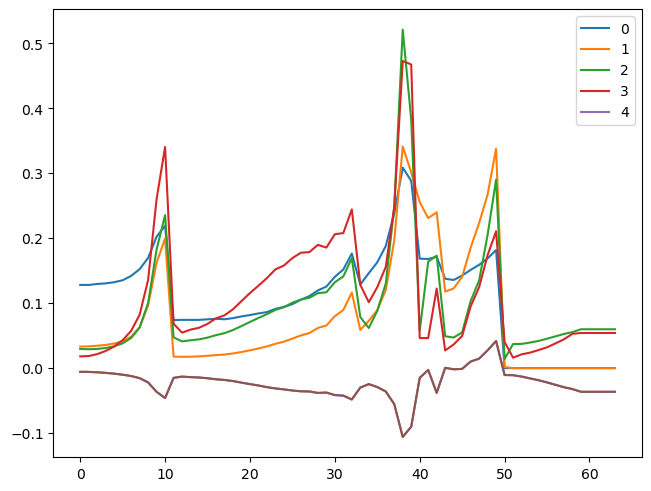

In [14]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5))

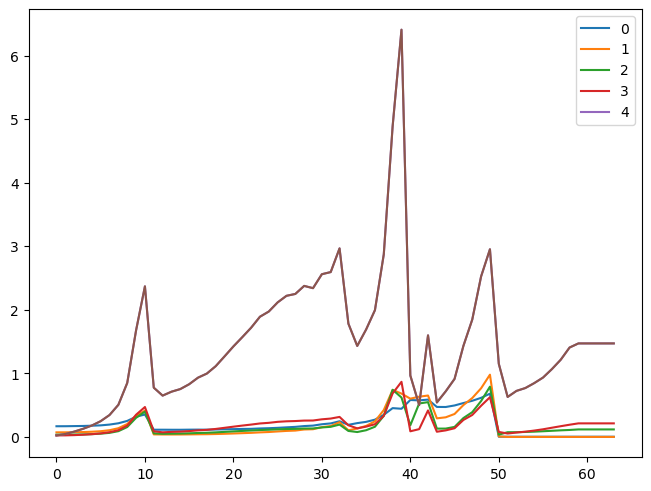

In [15]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5))

We see that our model is behaving badly, specifically in the last layer where the variance is very large. 

### PyTorch hooks
Again, PyTorch has already provided the hooks function. We simply need to register a hook to each layer, and specify whether we want the hook to be called during the forward or backward pass.

In [16]:
model = nn.Sequential(*cnn_layers())

In [17]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [18]:
def append_stats(i, mod, inp, out):
    act_means[i].append(to_cpu(out).mean())
    act_stds[i].append(to_cpu(out).std())

In [20]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.107,0.000,0,train
0.152,0.000,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

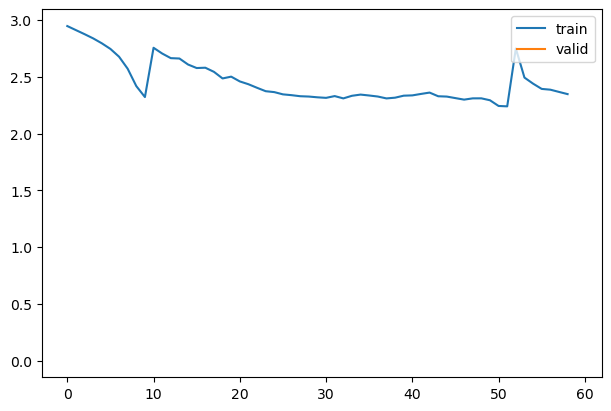

In [21]:
learn = fit(model)

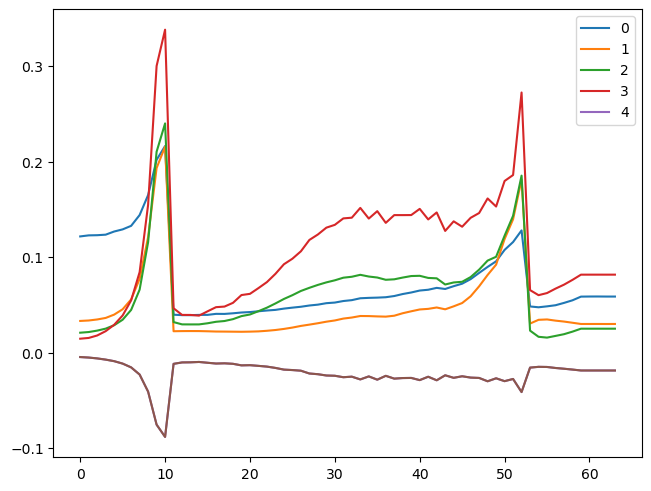

In [23]:
for l in act_means: plt.plot(l)
plt.legend(range(5))

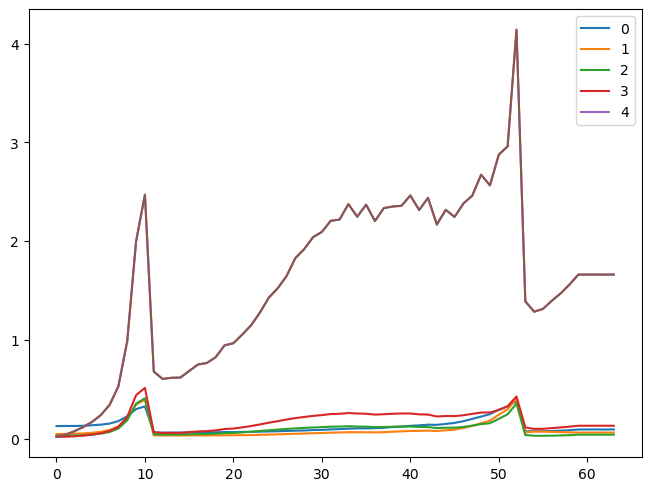

In [24]:
for l in act_stds: plt.plot(l)
plt.legend(range(5))

### Hook class
We can refactor the above into a Hook class. This is to allow us to release the memory when our model is deleted.

In [25]:
#|export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [34]:
def append_stats(hook, mod, inp, out):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    acts = to_cpu(out)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [35]:
model = nn.Sequential(*cnn_layers())

In [36]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.099,0.000,0,train
0.100,0.000,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

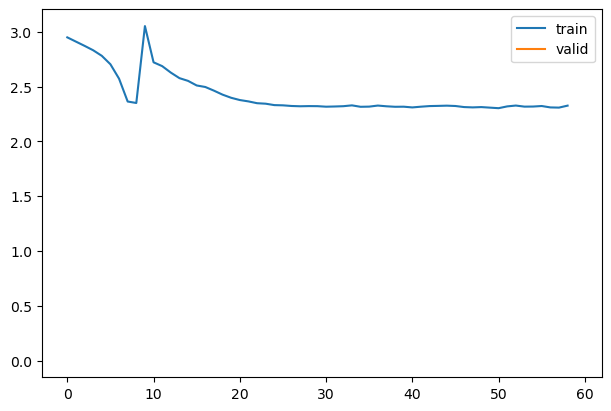

In [38]:
learn = fit(model)

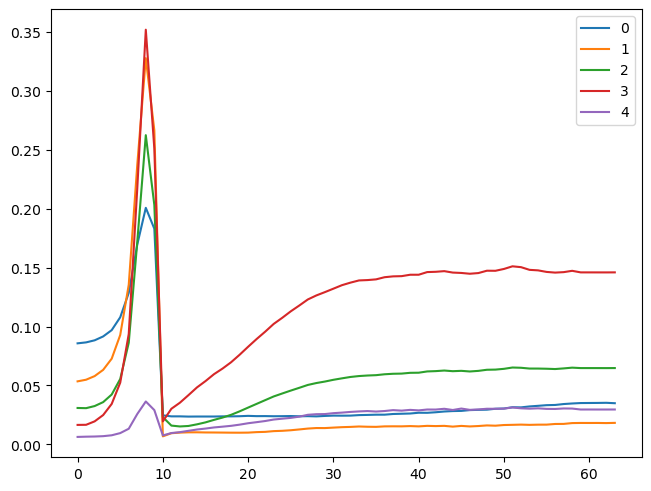

In [39]:
for h in hooks: 
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5))

### Hooks Context Manager
Using a context manager makes it easier for us to automate deletion of the hooks when we are done.

In [40]:
#|export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [41]:
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.129,0.000,0,train
0.179,0.000,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

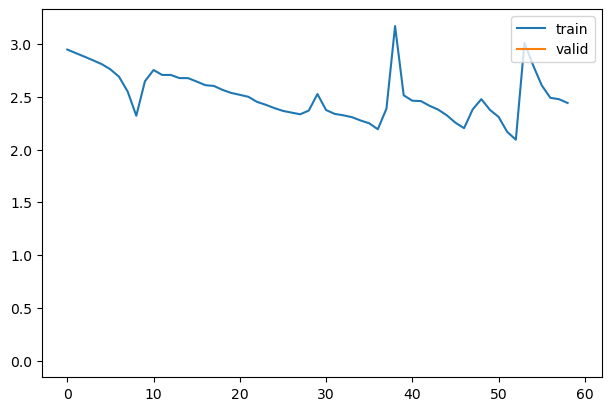

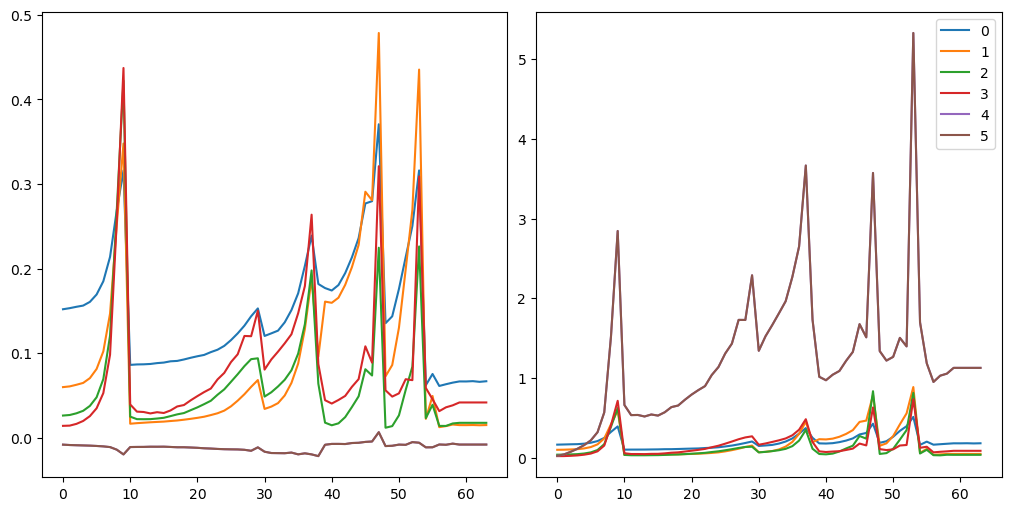

In [42]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for h in hooks:
        for i in 0, 1: axs[i].plot(h.stats[i])
    plt.legend(range(6))

### Hooks callback
We can also refactor our hooks as a callback.

In [43]:
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        if self.mods: mods = self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training):
            self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [44]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.102,0.000,0,train
0.100,0.000,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

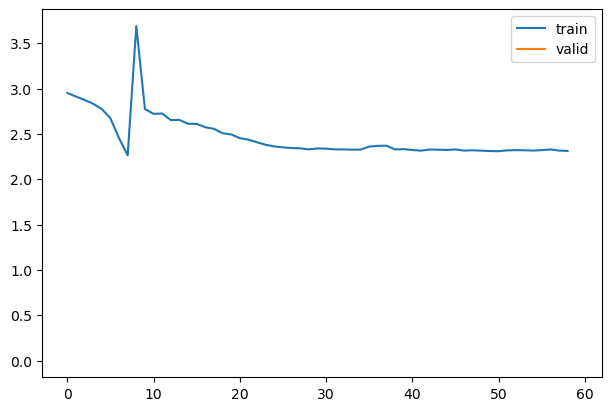

In [45]:
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

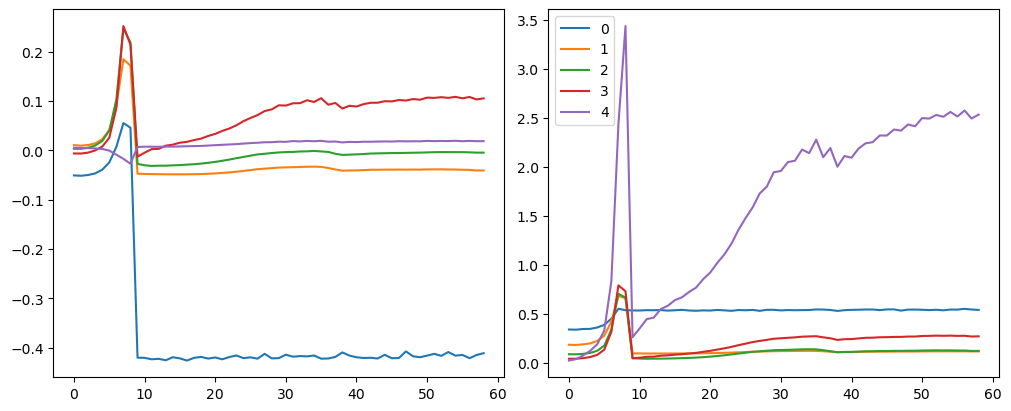

In [46]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

## Histograms
We can take a closer look at what is happening for the activation of each node in the layer.

In [49]:
#|export
def append_stats(hook, mod, inp, out):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    acts = to_cpu(out)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    # bins, min, max
    hook.stats[2].append(acts.abs().histc(40, 0, 10))

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

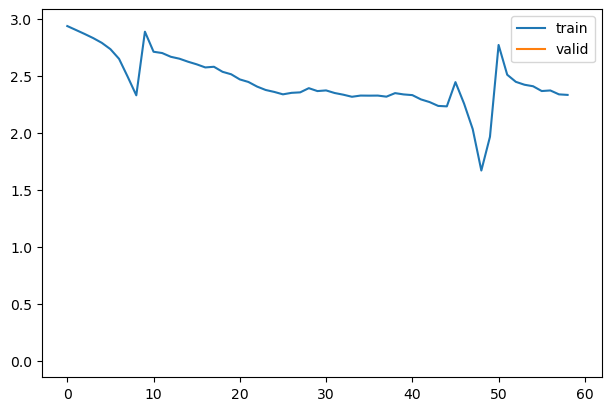

In [53]:
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc])

In [51]:
#| export
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

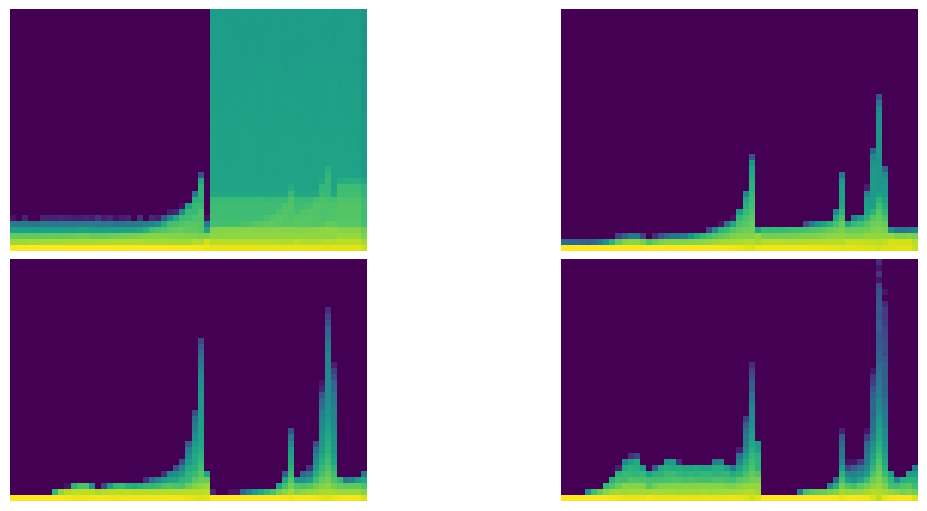

In [52]:
fig, axes = get_grid(len(hc), figsize=(11, 5))
for ax, h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

An explanation for the histograms above. Each column in each plot represents a scale from 0 (bottom) to 10 (top). The brighter the color, the more of that value and vice versa. Moving along the horizontal axis from left to right shows us the progression for each batch.

In other words, for the bottom left histogram's column (somewhere after the middle), we see that for this batch, there was a large number of activations that were effectively zero, and there were zero occurrences of activation that are approximately larger than one.

In other words, our model was effectively dead at this point, since most activations are zero.

We can dive deeper and count the percentage of pixels that are effectively 0 (or very close to).

In [54]:
#| export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

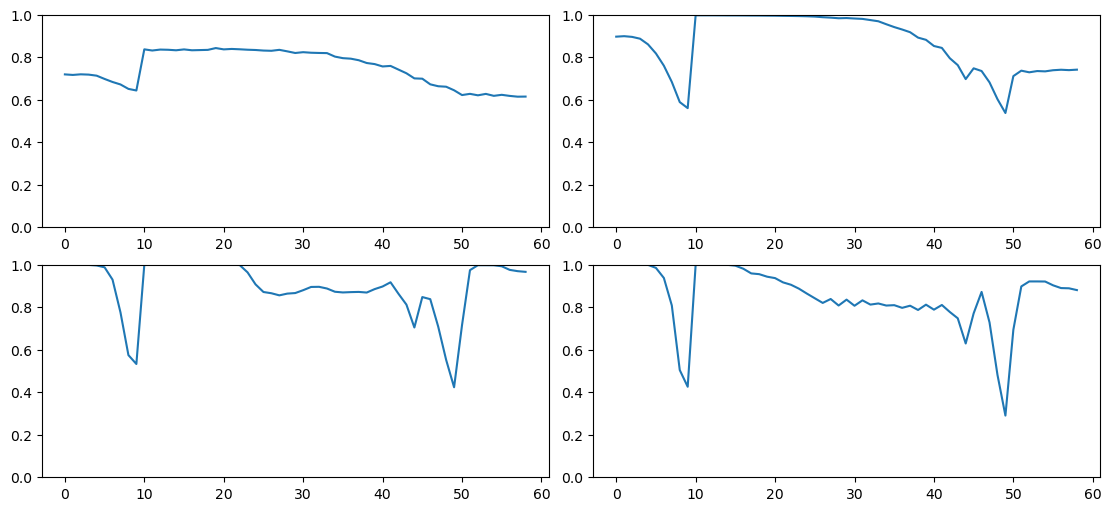

In [55]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

We see that most activations are almost 0. This is bad!

### ActivationStats
Lastly, we can refactor our code above to become callbacks that we can use while training our model.

In [56]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop):
        super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11, 5)):
        fig, axes = get_grid(len(self), figsize=figsize)
        for ax, h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [57]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.128,0.000,0,train
0.290,0.000,0,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

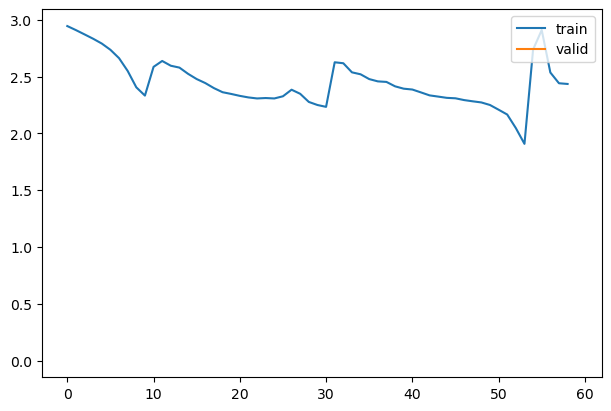

In [58]:
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats])

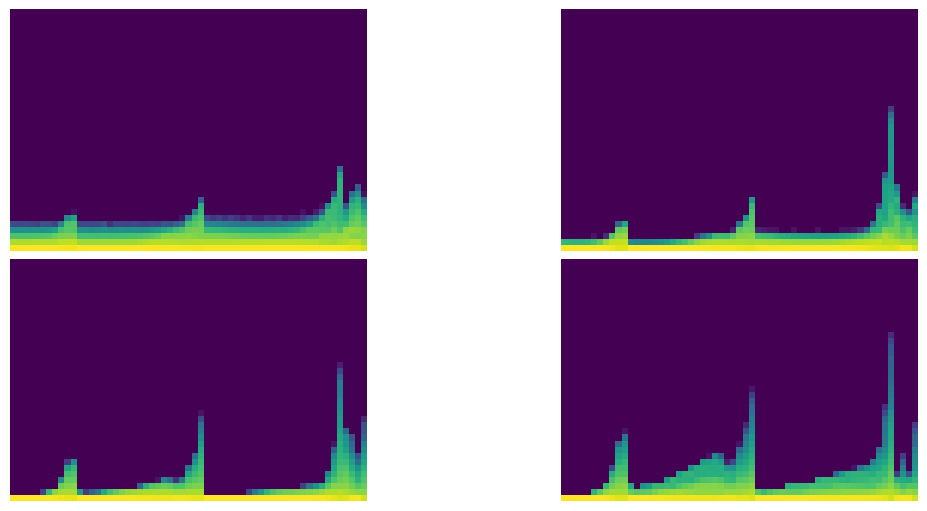

In [59]:
astats.color_dim()

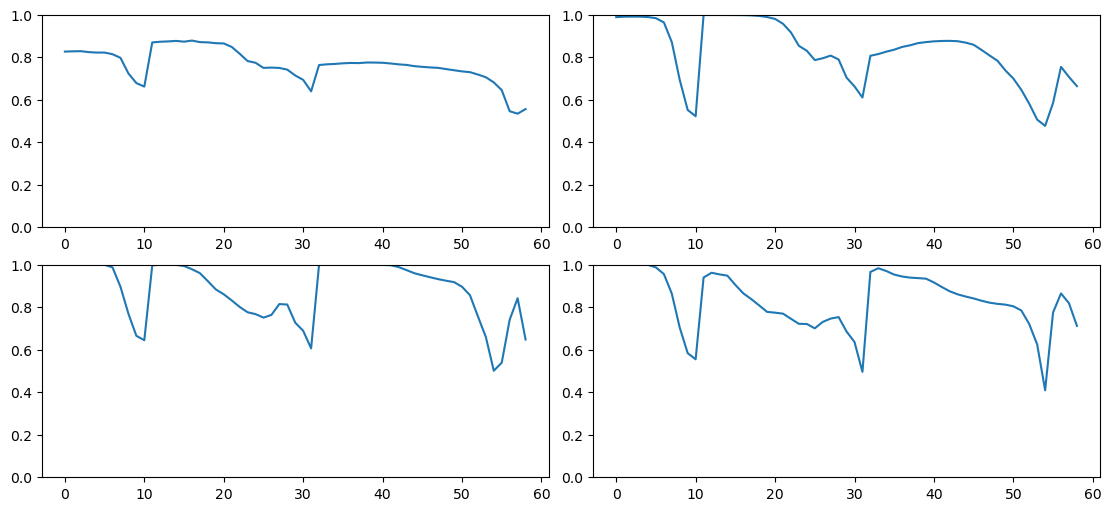

In [60]:
astats.dead_chart()

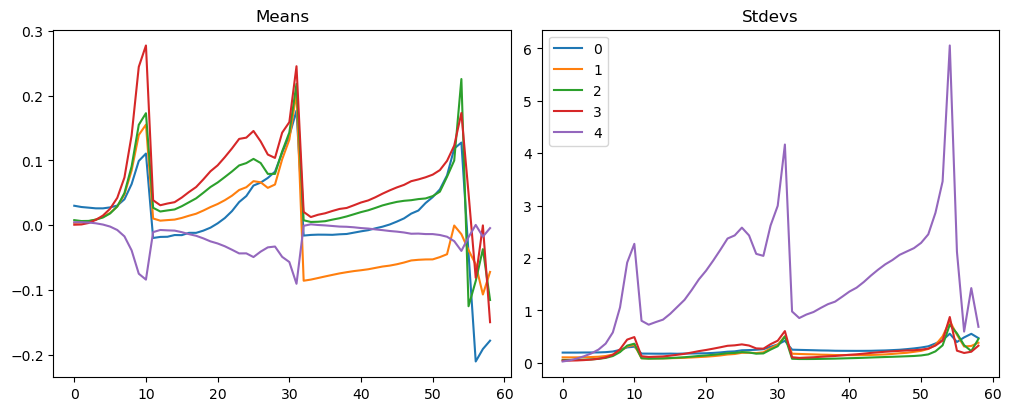

In [61]:
astats.plot_stats()

## Export

In [ ]:
import nbdev; nbdev.export.nb_export('10_activations.ipynb', lib_path='miniai')